In [1]:
import scipy.io as io
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from dataset.data_util import pil_load_img
from dataset.dataload import TextInstance
import torch.utils.data as data

画像、アノテーションを読み込み可視化.

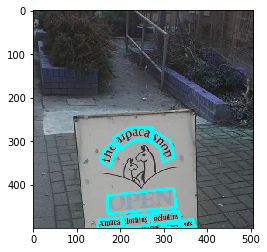

In [2]:
# Test image and annotations
img = cv2.imread("data/total-text/Images/Train/img1001.jpg")
mat_path = "data/total-text/gt/Train/poly_gt_img1001.mat"

# アノテーション結果を読み込み
annot = io.loadmat(mat_path)
polygons = []
for cell in annot['polygt']:
    x = cell[1][0]
    y = cell[3][0]
    text = cell[4][0] if len(cell[4]) > 0 else '#'
    ori = cell[5][0] if len(cell[5]) > 0 else 'c'

    if len(x) < 4:  # too few points
        continue
    pts = np.stack([x, y]).T.astype(np.int32)
    polygons.append(TextInstance(pts, ori, text))
        
# アノテーション結果を可視化
for polygon in polygons:
    poly = np.asarray(polygon["points"]).astype(np.int32)
    poly = poly.reshape((-1,1,2))
    img = cv2.polylines(img, [poly], True, (0,255,255), 5)
plt.imshow(img)
plt.show()

# TextSnake用の前処理
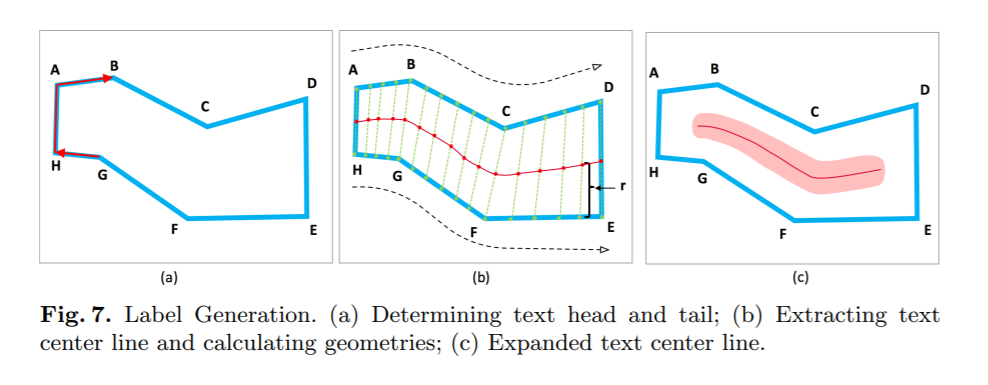

## 1)テキストセンターラインの抽出

### a)TopとBottomエッジを決める





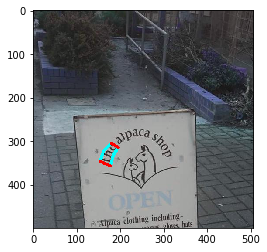

In [3]:
img = cv2.imread("data/total-text/Images/Train/img1001.jpg")

"""
find bottom and sideline..
cosine類似度を用いてテキスト領域のtop-bottomを探す。
エッジベクトル同士が並行かつ逆行するとき、cosine類似度は理想的に-1になる。
すべてのエッジベクトルにおけるcosine類似度を計算し、最も-1に近い２つのエッジをtop,bottomとしてラベルする。
"""
for i, polygon in enumerate(polygons):
    if polygon.text != '#':
        polygon.find_bottom_and_sideline()

# draw poly
poly = np.asarray(polygons[0]["points"]).astype(np.int32)
poly = poly.reshape((-1,1,2))
img = cv2.polylines(img, [poly], True, (0,255,255), 5)
# draw bottom
bottoms = np.asarray(polygons[0]["bottoms"]).astype(np.int32)
for b in bottoms:
    img = cv2.line(img, (poly[b[0]][0,0],poly[b[0]][0,1]), (poly[b[1]][0,0],poly[b[1]][0,1]), 
                   (255,0,0), 5)
# plt
plt.imshow(img)
plt.show()

### テキストのセンターラインを抽出しTCL pointsをサンプルする
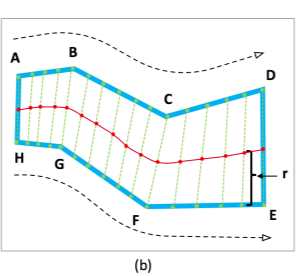

In [4]:
# テキスト領域をn_disk分割し,中心点のリスト(centerpoints)および上下のサイドライン(sideline1, 2)、
# そしてを求める。snakeの半径を求める。
# また得られた中心点とサイドラインからラベルとなるTR, TCLのマスクを作成する。
poly = polygons[0]
sideline1, sideline2, center_points, radius = poly.disk_cover()

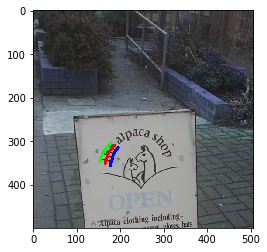

center points: (16, 2)
radius: (16,)


In [5]:
# The部分のcenterとsidelinesをプロット
img = cv2.imread("data/total-text/Images/Train/img1001.jpg")
#plot sidelines and centerpoints
sideline1_plt = np.asarray(sideline1).reshape((-1,1,2)).astype(np.int32)
img = cv2.polylines(img, [sideline1_plt], False, (0,0,255), 5)
sideline2_plt = np.asarray(sideline2).reshape((-1,1,2)).astype(np.int32)
img = cv2.polylines(img, [sideline2_plt], False, (0,255,0), 5)
center_points_plt = np.asarray(center_points).reshape((-1,1,2)).astype(np.int32)
img = cv2.polylines(img, [center_points_plt], False, (255,0,0), 5)
plt.imshow(img)
plt.show()
print("center points:", center_points.shape)
print("radius:",radius.shape)

In [6]:
"""
# ループ用
for i, polygon in enumerate(polygons):
    if polygon.text != '#':
        sideline1, sideline2, center_points, radius = polygon.disk_cover() 
print("center points:", center_points.shape)
print("radius:",radius.shape)
"""

'\n# ループ用\nfor i, polygon in enumerate(polygons):\n    if polygon.text != \'#\':\n        sideline1, sideline2, center_points, radius = polygon.disk_cover() \nprint("center points:", center_points.shape)\nprint("radius:",radius.shape)\n'

### 抽出したアノテーション情報を元にセグメンテーション用ラベルの作成

In [7]:
# セグメンテーションタスクなのでラベル情報は画像と同じ次元に投影。
# ここではラベル情報をMaskとして扱う.
# まずは各ラベルの入れ物を作り、そこに上記で得たcenter_point等のラベル情報を書き込む。
from dataset.dataload import make_text_center_line
H, W, _ = img.shape

tcl_mask = np.zeros(img.shape[:2], np.uint8)
radius_map = np.zeros(img.shape[:2], np.float32)
sin_map = np.zeros(img.shape[:2], np.float32)
cos_map = np.zeros(img.shape[:2], np.float32)

# radiusからradius_map, 隣接するcenterpointからsin_map, cos_mapを計算
# TCL maskはradiusの30%ほどの太さにすることで学習の安定化を図っている
make_text_center_line(sideline1, sideline2, center_points, radius, tcl_mask, 
                           radius_map, sin_map, cos_map, expand=0.3)

original image


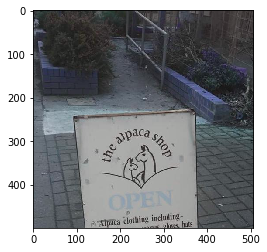

tcl_mask


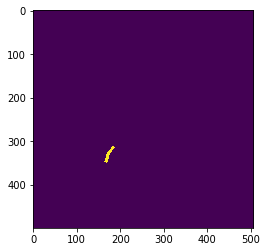

radius_map


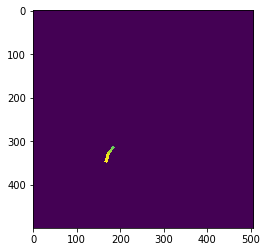

sin_map


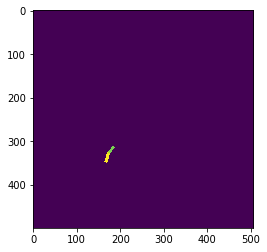

In [8]:
img = cv2.imread("data/total-text/Images/Train/img1001.jpg")
print("original image")
plt.imshow(img)
plt.show()
print("tcl_mask")
plt.imshow(tcl_mask)
plt.show()
print("radius_map")
plt.imshow(radius_map)
plt.show()
print("sin_map")
plt.imshow(sin_map)
plt.show()

### 全領域分をループで実施

tcl_mask


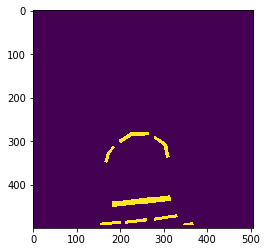

radius_map


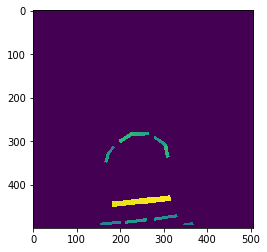

sin_map


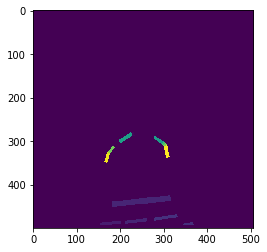

In [9]:
tcl_mask = np.zeros(img.shape[:2], np.uint8)
radius_map = np.zeros(img.shape[:2], np.float32)
sin_map = np.zeros(img.shape[:2], np.float32)
cos_map = np.zeros(img.shape[:2], np.float32)

for i, polygon in enumerate(polygons):
    if polygon.text != '#':
        sideline1, sideline2, center_points, radius = polygon.disk_cover()
        make_text_center_line(sideline1, sideline2, center_points, radius, tcl_mask, radius_map, sin_map, cos_map)
print("tcl_mask")
plt.imshow(tcl_mask)
plt.show()
print("radius_map")
plt.imshow(radius_map)
plt.show()
print("sin_map")
plt.imshow(sin_map)
plt.show()

In [10]:
# TRはアノテーションから得られるテキスト領域をラベルとする。
from dataset.dataload import make_text_region
tr_mask, train_mask = make_text_region(img, polygons)
# train_maskはアノテーションから得られる無視するべき領域

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show tr_mask area overlayed


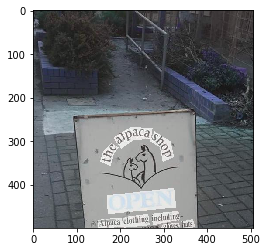

In [11]:
print("show tr_mask area overlayed")
plt.imshow(img/256+np.array([tr_mask,tr_mask,tr_mask]).transpose([1,2,0])*0.25)
plt.show()

### 上記の処理をDataloaderにまとめた

In [12]:
# Total-Text, SynthText両方に共通するデータセットクラス
# 細部のアノテーションデータ読み出し部(parse_mat)はデータセットに応じて要変更
# https://github.com/princewang1994/TextSnake.pytorch/blob/master/dataset/dataload.py
class TextDataset(data.Dataset):
    def __init__(self, transform):
        super().__init__()

        self.transform = transform

    def parse_mat(self, mat_path):
        """
        .mat file parser
        :param mat_path: (str), mat file path
        :return: (list), TextInstance
        """
        annot = io.loadmat(mat_path)
        polygon = []
        for cell in annot['polygt']:
            x = cell[1][0]
            y = cell[3][0]
            text = cell[4][0]
            if len(x) < 4: # too few points
                continue
            try:
                ori = cell[5][0]
            except:
                ori = 'c'
            pts = np.stack([x, y]).T.astype(np.int32)
            polygon.append(TextInstance(pts, ori, text))
        return polygon

    def make_text_region(self, image, polygons):

        tr_mask = np.zeros(image.shape[:2], np.uint8)
        train_mask = np.ones(image.shape[:2], np.uint8)

        for polygon in polygons:
            cv2.fillPoly(tr_mask, [polygon.points.astype(np.int32)], color=(1,))
            if polygon.text == '#':
                cv2.fillPoly(train_mask, [polygon.points.astype(np.int32)], color=(0,))
        return tr_mask, train_mask

    def fill_polygon(self, mask, polygon, value):
        """
        fill polygon in the mask with value
        :param mask: input mask
        :param polygon: polygon to draw
        :param value: fill value
        """
        rr, cc = drawpoly(polygon[:, 1], polygon[:, 0], shape=(cfg.input_size, cfg.input_size))
        mask[rr, cc] = value

    def make_text_center_line(self, sideline1, sideline2, center_line, radius, \
                              tcl_mask, radius_map, sin_map, cos_map, expand=0.3, shrink=1):

        # TODO: shrink 1/2 * radius at two line end
        for i in range(shrink, len(center_line) - 1 - shrink):

            c1 = center_line[i]
            c2 = center_line[i + 1]
            top1 = sideline1[i]
            top2 = sideline1[i + 1]
            bottom1 = sideline2[i]
            bottom2 = sideline2[i + 1]

            sin_theta = vector_sin(c2 - c1)
            cos_theta = vector_cos(c2 - c1)

            p1 = c1 + (top1 - c1) * expand
            p2 = c1 + (bottom1 - c1) * expand
            p3 = c2 + (bottom2 - c2) * expand
            p4 = c2 + (top2 - c2) * expand
            polygon = np.stack([p1, p2, p3, p4])

            self.fill_polygon(tcl_mask, polygon, value=1)
            self.fill_polygon(radius_map, polygon, value=radius[i])
            self.fill_polygon(sin_map, polygon, value=sin_theta)
            self.fill_polygon(cos_map, polygon, value=cos_theta)

    def get_training_data(self, image, polygons, image_id, image_path):
        H, W, _ = image.shape

        for i, polygon in enumerate(polygons):
            if polygon.text != '#':
                polygon.find_bottom_and_sideline()

        if self.transform:
            image, polygons = self.transform(image, copy.copy(polygons))

        tcl_mask = np.zeros(image.shape[:2], np.uint8)
        radius_map = np.zeros(image.shape[:2], np.float32)
        sin_map = np.zeros(image.shape[:2], np.float32)
        cos_map = np.zeros(image.shape[:2], np.float32)

        for i, polygon in enumerate(polygons):
            if polygon.text != '#':
                sideline1, sideline2, center_points, radius = polygon.disk_cover(n_disk=cfg.n_disk)
                self.make_text_center_line(sideline1, sideline2, center_points, radius, tcl_mask, radius_map, sin_map, cos_map)
        tr_mask, train_mask = self.make_text_region(image, polygons)

        # to pytorch channel sequence
        image = image.transpose(2, 0, 1)

        points = np.zeros((cfg.max_annotation, cfg.max_points, 2))
        length = np.zeros(cfg.max_annotation, dtype=int)

        for i, polygon in enumerate(polygons):
            pts = polygon.points
            points[i, :pts.shape[0]] = polygon.points
            length[i] = pts.shape[0]

        meta = {
            'image_id': image_id,
            'image_path': image_path,
            'annotation': points,
            'n_annotation': length,
            'Height': H,
            'Width': W
        }
        return image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta

    def get_test_data(self, image, image_id, image_path):
        H, W, _ = image.shape

        if self.transform:
            image, polygons = self.transform(image)

        # to pytorch channel sequence
        image = image.transpose(2, 0, 1)

        meta = {
            'image_id': image_id,
            'image_path': image_path,
            'Height': H,
            'Width': W
        }
        return image, meta

    def __len__(self):
        raise NotImplementedError()

In [14]:
# TextDatasetを継承し、TotalText用にアノテーションデータ読み込み部をカスタマイズ。
class TotalText(TextDataset):
    def __init__(self, data_root, ignore_list=None, is_training=True, transform=None):
        super().__init__(transform)
        self.data_root = data_root
        self.is_training = is_training

        if ignore_list:
            with open(ignore_list) as f:
                ignore_list = f.readlines()
                ignore_list = [line.strip() for line in ignore_list]
        else:
            ignore_list = []
            
        # data_root/TrainまたはTestにあるignore_listに含まれない画像データを学習に利用
        self.image_root = os.path.join(data_root, 'Images', 'Train' if is_training else 'Test')
        self.annotation_root = os.path.join(data_root, 'gt', 'Train' if is_training else 'Test')
        # ファイルリストを生成
        self.image_list = os.listdir(self.image_root)
        self.image_list = list(filter(lambda img: img.replace('.jpg', '') not in ignore_list, self.image_list))
        #画像ファイルと同じ名前のアノテーションファイルをリスト化
        self.annotation_list = ['poly_gt_{}.mat'.format(img_name.replace('.jpg', '')) for img_name in self.image_list]

    # アノテーションデータ読み込み用
    # polygonsはセグメンテーションと同様で、文字が存在する領域をポリゴン形式で返す。
    def parse_mat(self, mat_path):
        """
        .mat file parser
        :param mat_path: (str), mat file path
        :return: (list), TextInstance
        """
        annot = io.loadmat(mat_path)
        polygons = []
        for cell in annot['polygt']:
            x = cell[1][0]
            y = cell[3][0]
            text = cell[4][0] if len(cell[4]) > 0 else '#'
            ori = cell[5][0] if len(cell[5]) > 0 else 'c'

            if len(x) < 4:  # too few points
                continue
            pts = np.stack([x, y]).T.astype(np.int32)
            polygons.append(TextInstance(pts, ori, text))

        return polygons
    
    # 指定idex(item)の画像とアノテーションを読み込む
    def __getitem__(self, item):
        image_id = self.image_list[item]
        image_path = os.path.join(self.image_root, image_id)

        # Read image data
        image = pil_load_img(image_path)

        # Read annotation
        annotation_id = self.annotation_list[item]
        annotation_path = os.path.join(self.annotation_root, annotation_id)
        polygons = self.parse_mat(annotation_path)
        
        
        for i, polygon in enumerate(polygons):
            if polygon.text != '#':
                polygon.find_bottom_and_sideline()

        return self.get_training_data(image, polygons, image_id=image_id, image_path=image_path)
    
    # データセット長を返す関数。データローダに必要。
    def __len__(self):
        return len(self.image_list)